**DSBA 6156 Final Project**

Model by Xavier Zuo

In [1]:
# Load data
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Must set path to the actual location of the data on local google drive
path = '/content/drive/MyDrive/6156_Project_Shared/diabetes_binary_health_indicators_BRFSS2015.csv'
data = pd.read_csv(path,sep=",",)
drive.flush_and_unmount()

# Load common files and programs
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, precision_recall_fscore_support
from sklearn.metrics import average_precision_score, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


Mounted at /content/drive


In [ ]:
# Exploratory Analysis

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


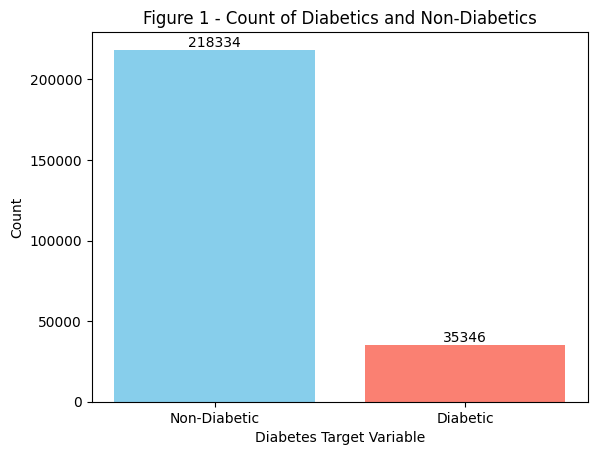

In [8]:
# Count the occurrences of positive and negative values
count_values = data['Diabetes_binary'].value_counts()

#print("Non-Diabetic: ",count_values[0])
#print("Diabetic:     ",count_values[1])

# Plot the counts
plt.bar(count_values.index, count_values.values, color=['skyblue', 'salmon'])
plt.title('Figure 1 - Count of Diabetics and Non-Diabetics')
plt.xlabel('Diabetes Target Variable')
plt.ylabel('Count')
plt.xticks(count_values.index, ['Non-Diabetic', 'Diabetic'])

# Add count values above the bars
for i, value in enumerate(count_values.values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

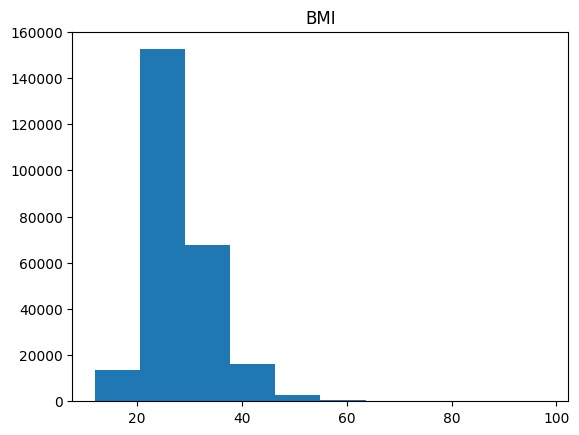

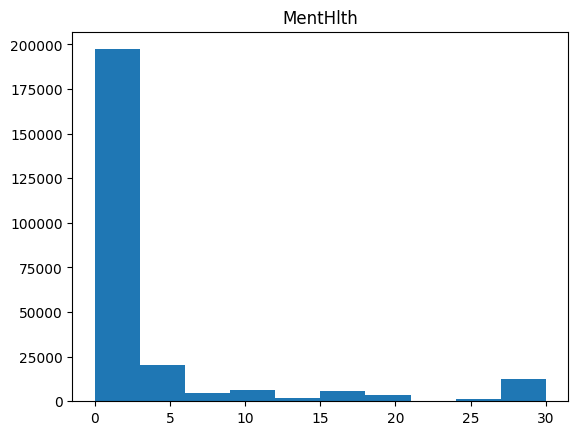

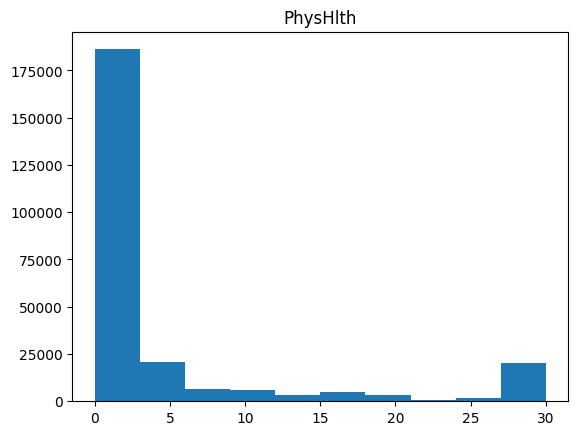

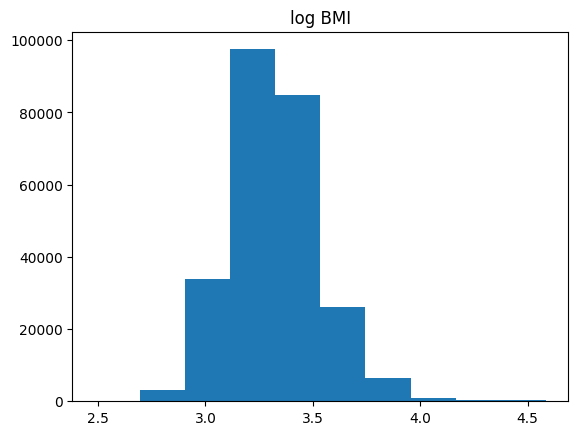

In [ ]:
# Data Exploration and Transformation

plt.hist(data['BMI'])
plt.title('BMI')
plt.show()
plt.hist(data['MentHlth'])
plt.title('MentHlth')
plt.show()
plt.hist(data['PhysHlth'])
plt.title('PhysHlth')
plt.show()

# Run Transformation on Data
# In classification (versus linear regression), variables do not need to be normally distributed
# Log transformation can be used, but is not needed and might not help with model performance
data['BMI'] = data['BMI'].apply(lambda x: math.log(x))

# Check BMI Again
plt.hist(data['BMI'])
plt.title('log BMI')
plt.show()

In [ ]:
# Generate X and y datasets and create train-test split
X = data.drop(columns='Diabetes_binary')
y = data['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

In [ ]:
# Split X into categorical vs. continuous features
#continuous = ["BMI", "MentHlth", "PhysHlth"]
#X_categorical = X.drop(columns=continuous)
#X_continuous = X[continuous]

X_categorical = X.drop(columns=X.columns)
X_continuous = X

In [ ]:
# Use Standard Scaler on continuous variables and use OneHotEncoder on categorical to create preprocess
preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                              X_categorical.columns),
                             (StandardScaler(), X_continuous.columns))

# Model Selection
#classifier1 = RandomForestClassifier()
#classifier2 = LogisticRegression(max_iter=1000)
#classifier3 = XGBClassifier()

#models = VotingClassifier(estimators=[('RF', classifier1), ('LR', classifier2), ('XGB', classifier3)], voting='soft')
#Extra = ExtraTreesClassifier()
#DT = DecisionTreeClassifier(class_weight='balanced',random_state=42)
DT = DecisionTreeClassifier(random_state=42)

In [ ]:
# Make Pipeline Without SMOTE
pipe1 = Pipeline([('preprocess', preprocess),('DT', DT)])
#pipe1.get_params()
param_grid1 = {'DT__max_features': range(6,20,2)
                , 'DT__max_depth': range(3,10,1)
               }

### Do NOT use SMOTE or similar strategy ===> generate noise and overfit ===> decreased performance on test data
# Setup SMOTE (oversampling)
#smote_over = SMOTE(sampling_strategy='auto')
# Resample Training Data Only via SMOTE
#X_train_resampled, y_train_resampled = smote_over.fit_resample(X_train, y_train)

# GridSearchCV
grid1 = GridSearchCV(pipe1,param_grid1, return_train_score=True, scoring='roc_auc')
grid1.fit(X_train,y_train)
print(f"Best mean cross-validation score: {grid1.best_score_:.3f}")
print(f"Best parameters: {grid1.best_params_}")

# Generate prediction (use probability prediction)
best_model1 = grid1.best_estimator_
y_prob1 = best_model1.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score on test data using probability predictions
roc_auc_test1 = roc_auc_score(y_test, y_prob1)  # Use the probability of the positive class
print(f"Score of Test Data: {roc_auc_test1:.3f}")

Best mean cross-validation score: 0.817
Best parameters: {'DT__max_depth': 8, 'DT__max_features': 16}
Score of Test Data: 0.814


### Confusion Matrix and ROC-AUC (for Test Data)

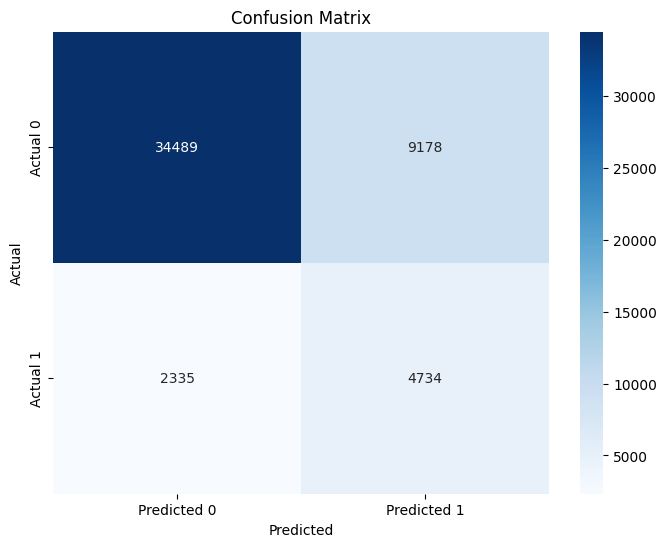

In [ ]:
best_model1 = grid1.best_estimator_
y_pred1 = best_model1.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)

# (Added by Xavier) Change Threshold
threshold = 0.2
y_pred1 = (best_model1.predict_proba(X_test)[:, 1] >= threshold).astype('float')
conf_matrix = confusion_matrix(y_test, y_pred1)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.773
Precision: 0.340
Recall: 0.670
F1 Score: 0.451
ROC AUC: 0.814


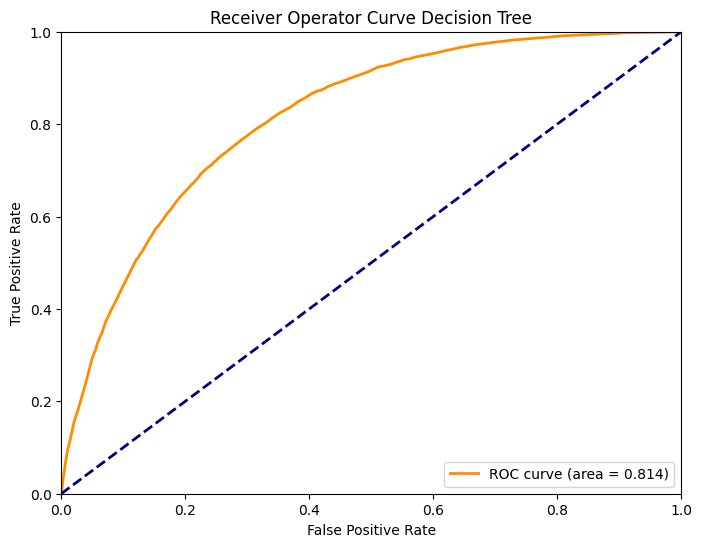

In [ ]:
# Calculate ROC AUC
y_pred_proba = best_model1.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add a circle at the threshold
#index = np.where(fpr >= (threshold))[0][0]
#plt.scatter(fpr[index], tpr[index], color='red', s=100, marker='o', label=f'Threshold = {threshold}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Curve Decision Tree')
plt.legend(loc="lower right")
plt.show()

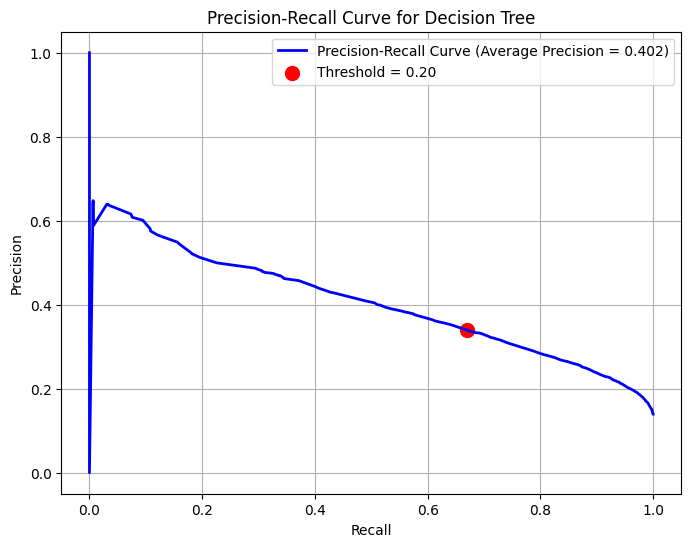

In [ ]:
# Generate Precision Recall and Average Precision

# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate Average Precision
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall Curve with Average Precision in the Legend
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (Average Precision = {average_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decision Tree')

# (Added by Xavier) Add a circle at the threshold
# threshold = 0.25
# Find the index of the closest threshold value in the array
closest_threshold_index = np.argmin(np.abs(thresholds - threshold))
# Mark the threshold with a circle
plt.scatter(recall[closest_threshold_index], precision[closest_threshold_index], c='r', marker='o', s=100, label=f'Threshold = {thresholds[closest_threshold_index]:.2f}')

plt.legend(loc='upper right')
plt.grid(True)
plt.show()